In [1]:
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import meaniou
import imageio.v2 as imageio
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import random

Lets first take a look at the images. Because the images are all separated into separate folders, we can use glob to get all the images.

In [ ]:
images = glob.glob('../data/data*/data*/CameraRGB/*.png')
masks = glob.glob('../data/data*/data*/CameraSeg/*.png')

Here we can see the side by side of the images and masks supplied by the dataset. 

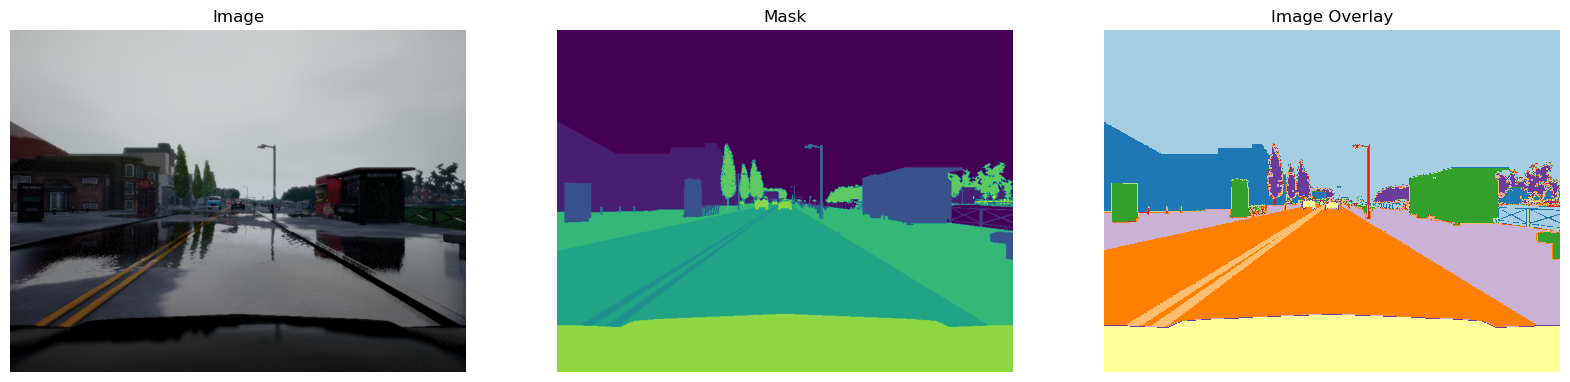

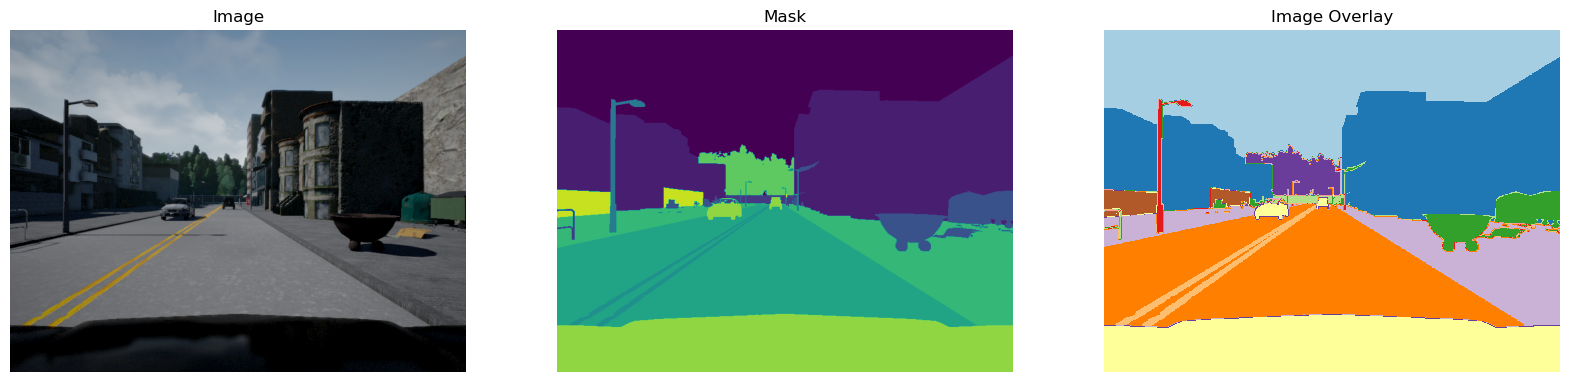

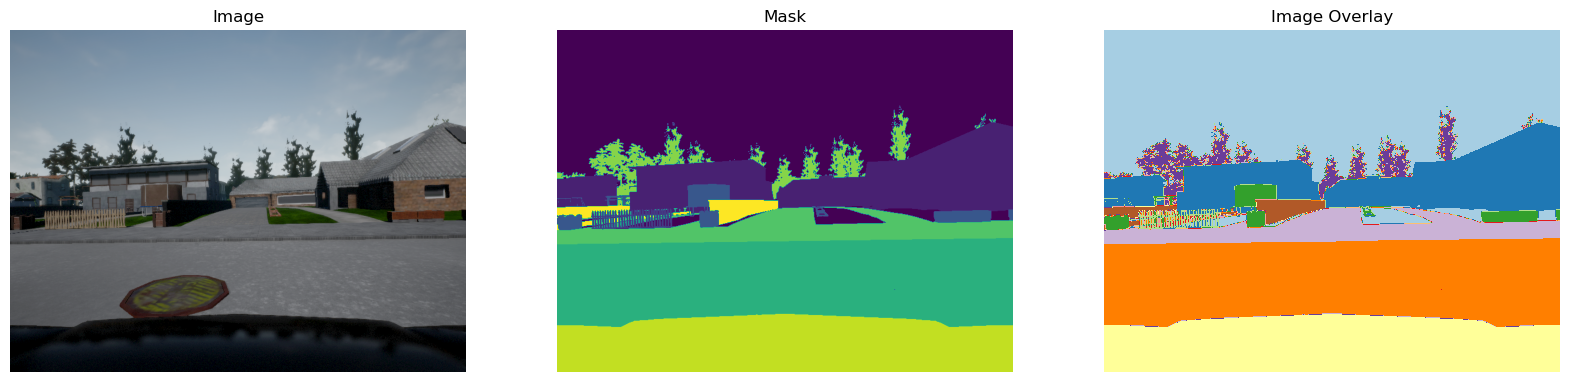

In [3]:
for i in range(3):
    N = random.randint(0, len(images) - 1)

    img = imageio.imread(images[N])
    mask = imageio.imread(masks[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Mask')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

Now we will load in all the images with tensorflow and store it in a tensorflow dataset. We will create some helper functions so that they can be mapped to a tensorflow dataset

In [ ]:
def get_dataset(batch_size, buffer_size, img_paths, mask_paths):
    def load_imgs(img_path, mask_path):
        input_img = tf_io.read_file(img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf.image.convert_image_dtype(input_img, tf.float32)
        input_img = tf.image.resize(input_img, (256, 256), method='nearest')

        input_mask = tf_io.read_file(mask_path)
        input_mask = tf_io.decode_png(input_mask, channels=3)
        input_mask = tf.math.reduce_max(input_mask, axis=-1, keepdims=True)
        input_mask = tf.image.resize(input_mask, (256, 256), method='nearest')

        return input_img, input_mask
    image_list = tf.constant(img_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_imgs, num_parallel_calls=tf_data.AUTOTUNE)
    #return dataset.cache().shuffle(buffer_size).batch(batch_size)
    dataset = dataset.cache().batch(batch_size)

Before we go ahead with the model, we will first create a validation split so we can see some metrics while the model runs

In [5]:
val_samples = 1000
#N = random.randint(0, val_samples)
#random.Random(N).shuffle(images)
#random.Random(N).shuffle(masks)
train_img_paths = images[:-val_samples]
train_mask_paths = masks[:-val_samples]
val_img_paths = images[-val_samples:]
val_mask_paths = masks[-val_samples:]

#Small sample for fast testing
#train_img_paths = images[:1000]
#train_mask_paths = masks[:1000]
#val_img_paths = images[-400:]
#val_mask_paths = masks[-400:]

train_data = get_dataset(32, 500, train_img_paths, train_mask_paths)
val_data = get_dataset(32, 500, val_img_paths, val_mask_paths)

Here we will create some functions so that we can see how the model's predicted masks compare with the validation masks

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(in_model, dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = in_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

We can test this function quickly to see if it is working properly, and it is.

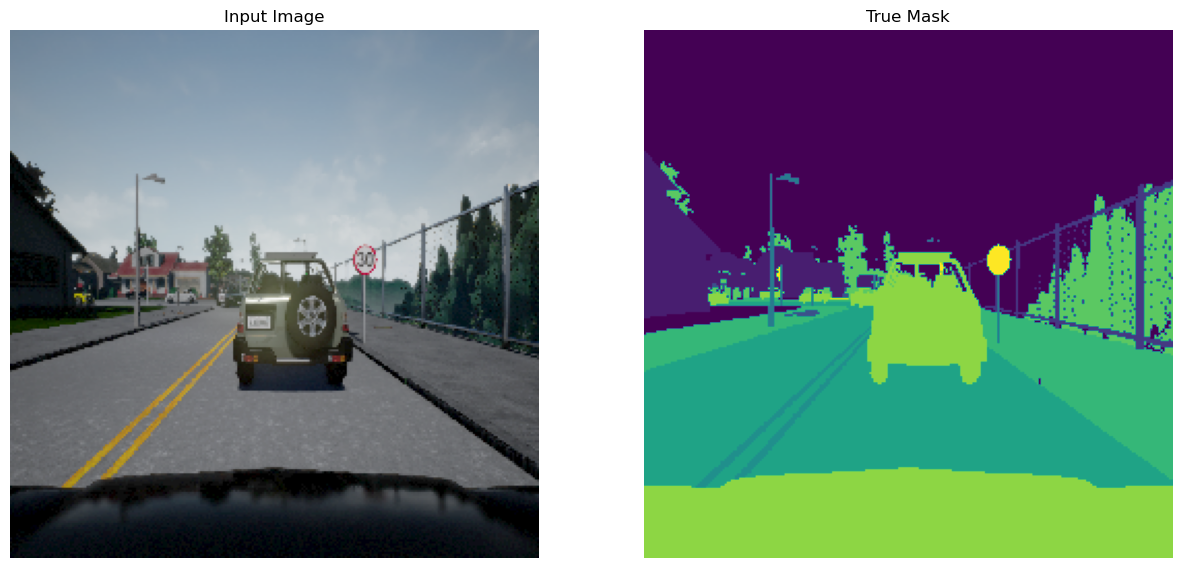

In [7]:
for image,mask in train_data.take(1):
    display([image[0], mask[0]])

# First model
Next we'll create a U-Net model where the model first downsamples the inputs before upsampling them back for predictions. We will start off with a model that is not too complex. First we'll define some functions that will help with model creation

In [59]:
def conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    #Ensures dimension match before concatenation
    target_shape = tf.shape(x)[1:3]
    conv_features = tf.image.resize(conv_features, target_shape)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_filters)
    return x

Now we will create the model

In [60]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

bottleneck = conv_block(p4, 1024)

u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)

conv10 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same', activation='softmax')(conv10)

unet_model = tf.keras.Model(inputs, outputs)

In [61]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy', meaniou.UpdatedMeanIoU(num_classes=13)])
#callback = tf.keras.callbacks.ModelCheckpoint('model1.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

We will test on only 10 epochs just to get a quick glance at the performance of the model. We can see that it is actually performing decently well for a relatively simple model. Accuracy isn't the best metric for this model, but still it is decently high.

In [62]:
model1_hist = unet_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease])

Epoch 1/10
125/125 [==============================] - 95s 755ms/step - loss: 1.0780 - accuracy: 0.6387 - updated_mean_io_u_6: 0.1816 - val_loss: 0.7030 - val_accuracy: 0.7829 - val_updated_mean_io_u_6: 0.2736 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 94s 756ms/step - loss: 0.5191 - accuracy: 0.8339 - updated_mean_io_u_6: 0.3295 - val_loss: 0.4995 - val_accuracy: 0.8639 - val_updated_mean_io_u_6: 0.3857 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 95s 759ms/step - loss: 0.3523 - accuracy: 0.8912 - updated_mean_io_u_6: 0.4119 - val_loss: 0.3443 - val_accuracy: 0.8986 - val_updated_mean_io_u_6: 0.4382 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 95s 761ms/step - loss: 0.2735 - accuracy: 0.9150 - updated_mean_io_u_6: 0.4556 - val_loss: 0.2919 - val_accuracy: 0.9137 - val_updated_mean_io_u_6: 0.4710 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 95s 761ms/step - loss: 0.2263 - accuracy: 

This was meant to save the model as well as the history of it so that it would not need to be run everytime for the results. However, with the inclusion of a custom metric, it caused it to be harder to implement properly. 

In [12]:
#unet_model.save('./models/model1.keras')
#with open('./models/model1Hist', 'wb') as f:
#    pickle.dump(unet_model.history, f)

INFO:tensorflow:Assets written to: ram://1ac38db2-07c2-4773-a6fb-ae9a19249bfa/assets


INFO:tensorflow:Assets written to: ram://1ac38db2-07c2-4773-a6fb-ae9a19249bfa/assets


While the mask isn't perfect, it's doing surprisingly well for a first model. The outlines of the objects aren't as sharp as the true mask, but it is clearly marking larger objects. It can pretty clearly classify the front of the user's car, and most of the road, but it struggles with trees, cars, and pretty much everything else. Still, this is a solid first model and there is a lot we can change with the model to improve it.

1/1 [==============================] - 0s 25ms/step


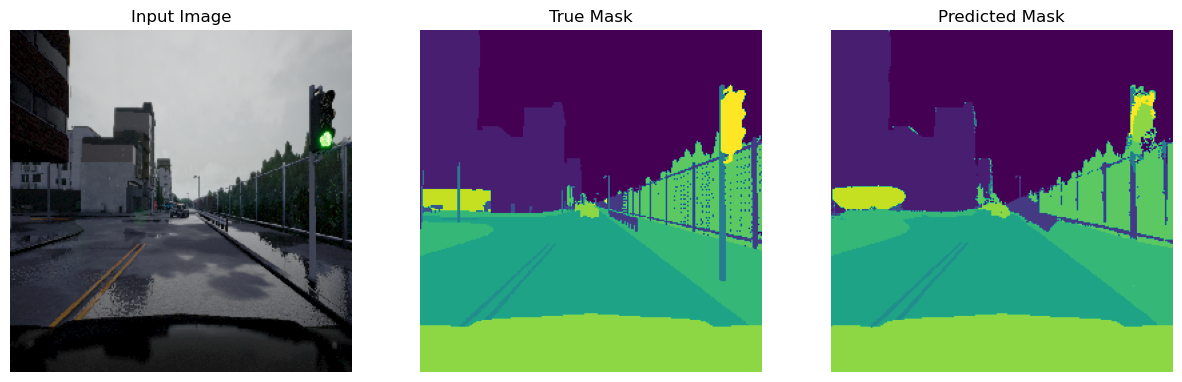

1/1 [==============================] - 0s 17ms/step


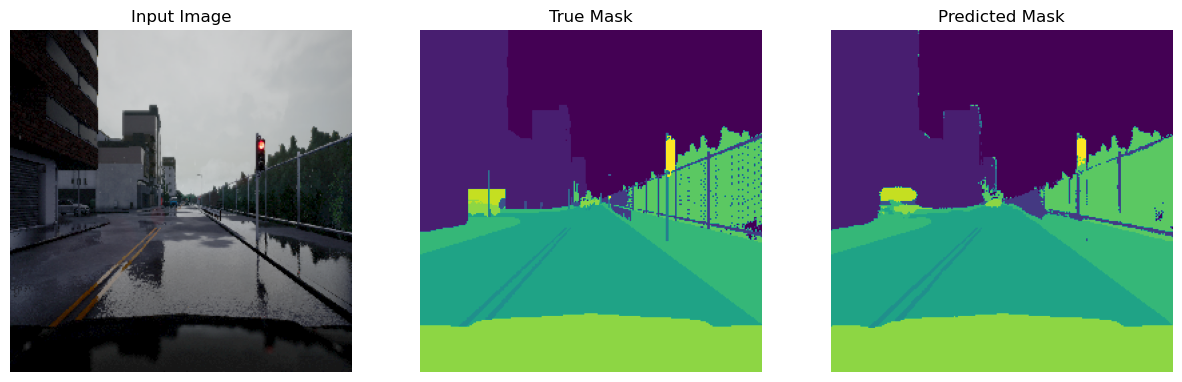

1/1 [==============================] - 0s 16ms/step


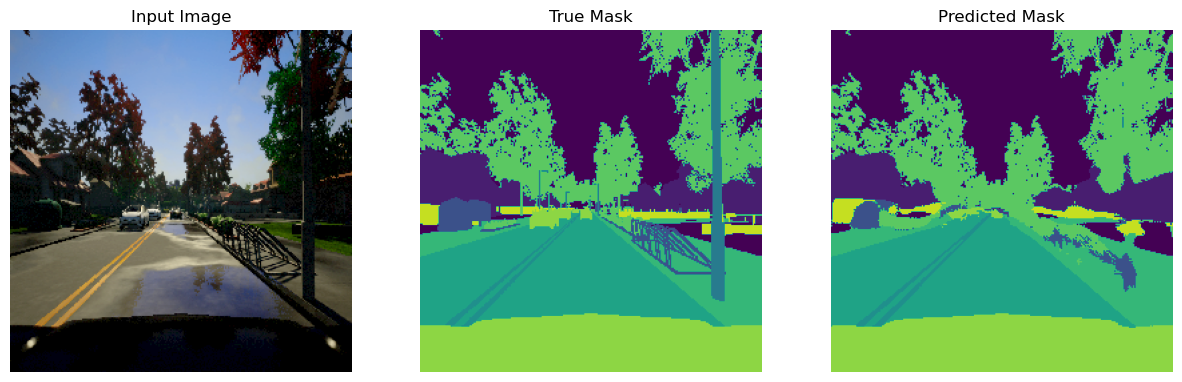

In [75]:
#unet_model = tf.keras.models.load_model('./models/model1.keras', custom_objects={'UpdatedMeanIoU':meaniou.UpdatedMeanIoU(num_classes=13)})
#with open('./models/model1Hist', 'rb') as f:
#    model1_hist = pickle.load(f)
show_predictions(unet_model, train_data, 3)

# Simpler upsampling layer
Here we will change some things with the original model that may improve the performance. For one, we will change the dropout so that it only occurs when specified, and the amount can be changed. We will also change the Conv2DTranspose into an UpSampling2D layer, which is a simpler method of scaling and should be faster. In order to properly replace Conv2DTranspose, we will need to insert a Conv2D layer after the upsampling in order to still learn from it. It may not necessarily be better, but it is worth a shot. We will also add a BatchNormalization and LeakyReLU within each convolution block.

In [29]:
def conv2_block(x, n_filters, dropout=0):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    if dropout>0:
        x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def downsample2_block(x, n_filters, dropout=0):
    f = conv2_block(x, n_filters, dropout)
    p = layers.MaxPool2D(2)(f)
    return f, p

def upsample2_block(x, conv_features, n_filters, dropout=0):
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv2_block(x, n_filters, dropout)
    return x

We will add a softmax activation for the final convolutional layer. Before we start downsampling, we will also normalize the data.

In [30]:
inputs = layers.Input(shape=(256,256,3))
inputs = layers.Lambda(lambda x: x / 255.0)(inputs)

f1, p1 = downsample2_block(inputs, 64)
f2, p2 = downsample2_block(p1, 128, 0.1)
f3, p3 = downsample2_block(p2, 256, 0.1)
f4, p4 = downsample2_block(p3, 512, 0.2)

bottleneck = conv2_block(p4, 1024, 0.3)

u6 = upsample2_block(bottleneck, f4, 512, 0.2)
u7 = upsample2_block(u6, f3, 256, 0.1)
u8 = upsample2_block(u7, f2, 128, 0.1)
u9 = upsample2_block(u8, f1, 64)

#conv = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same', activation='softmax')(u9)
unet2_model = tf.keras.Model(inputs, outputs)

In [31]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet2_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy', meaniou.UpdatedMeanIoU(num_classes=13)])
#callback = tf.keras.callbacks.ModelCheckpoint('model2.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

In [32]:
model2_hist = unet2_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease])

Epoch 1/10
125/125 [==============================] - 122s 965ms/step - loss: 0.4466 - accuracy: 0.8754 - updated_mean_io_u_3: 0.4064 - val_loss: 2.4288 - val_accuracy: 0.5283 - val_updated_mean_io_u_3: 0.1488 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 119s 951ms/step - loss: 0.1852 - accuracy: 0.9439 - updated_mean_io_u_3: 0.5527 - val_loss: 2.1941 - val_accuracy: 0.5714 - val_updated_mean_io_u_3: 0.1711 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 121s 966ms/step - loss: 0.1415 - accuracy: 0.9560 - updated_mean_io_u_3: 0.6192 - val_loss: 0.9547 - val_accuracy: 0.7711 - val_updated_mean_io_u_3: 0.3604 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 118s 945ms/step - loss: 0.1137 - accuracy: 0.9638 - updated_mean_io_u_3: 0.6664 - val_loss: 0.2607 - val_accuracy: 0.9203 - val_updated_mean_io_u_3: 0.5731 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 118s 946ms/step - loss: 0.0963 - accuracy: 0.9686 - up

In [25]:
#unet2_model.save('./models/model2.keras')
#with open('./models/model2Hist', 'wb') as f:
#    pickle.dump(unet2_model.history, f)

This model is performing much better than the baseline model. While the accuracy is pretty similar, the mean IoU is much higher, and the segmentations in the mask are much more apparent/distinct. While it might be thanks to changing to Upsampling2D from Conv2dTranspose, it could have also been thanks to a lot of the other changes that were made in this model. As such, we will test the model again with Conv2DTranspose and compare.

1/1 [==============================] - 0s 17ms/step


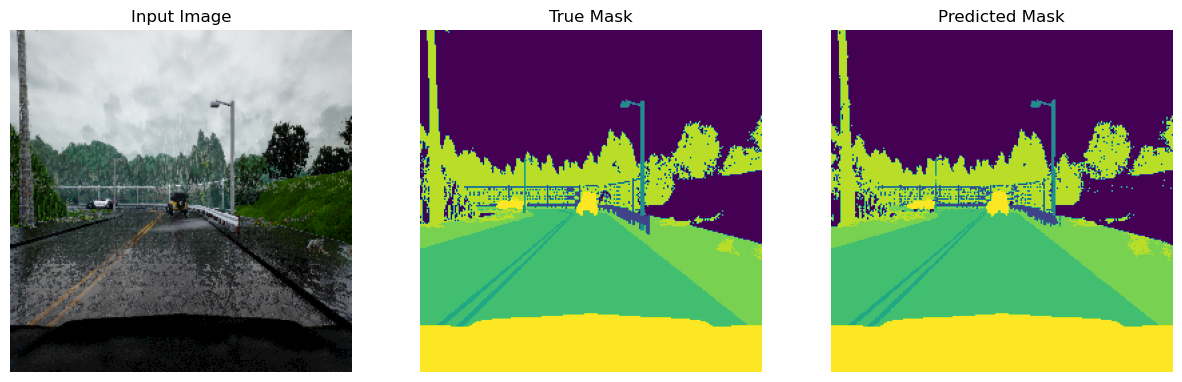

1/1 [==============================] - 0s 23ms/step


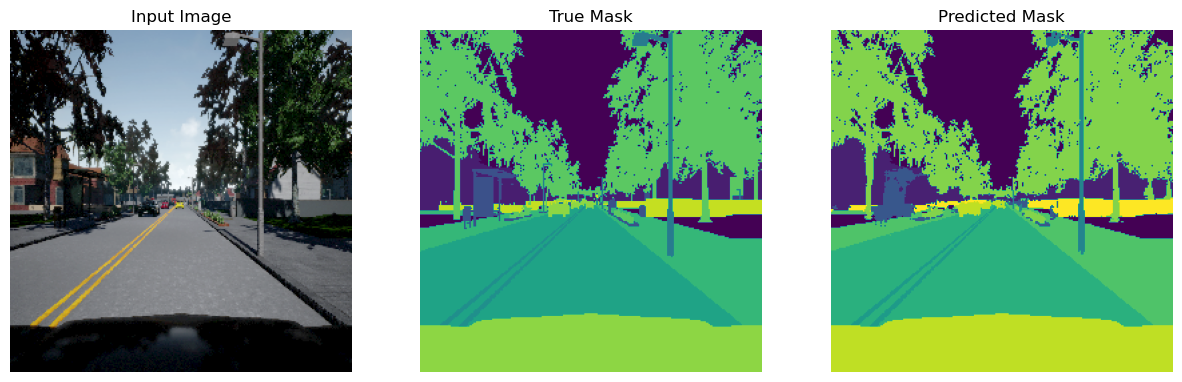

1/1 [==============================] - 0s 17ms/step


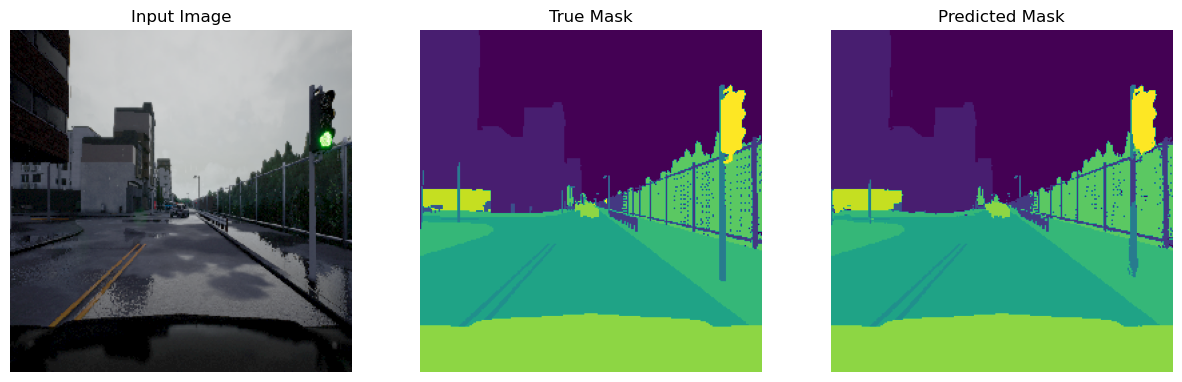

In [74]:
#unet2_model = tf.keras.models.load_model('./models/model2.keras')
#with open('./models/model2Hist', 'rb') as f:
#    model2_hist = pickle.load(f)
show_predictions(unet2_model, train_data, 3)

# Third model
This model is essentially the same as the model above, except we swap the Upsampling2D back into Conv2DTranspose to see if with all the changes, it can perform as well as the Upsampling2D model did.

In [68]:
def conv3_block(x, n_filters, dropout=0):
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.LeakyReLU()(x)
    if dropout>0:
        x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.LeakyReLU()(x)
    return x

def downsample3_block(x, n_filters, dropout=0):
    f = conv3_block(x, n_filters, dropout)
    p = layers.MaxPooling2D(2)(f)
    return f, p

def upsample3_block(x, conv_features, n_filters, dropout=0):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv3_block(x, n_filters, dropout)
    return x

In [69]:
inputs = layers.Input(shape=(256,256,3))
inputs = layers.Lambda(lambda x: x / 255.0)(inputs)

f1, p1 = downsample3_block(inputs, 64)
f2, p2 = downsample3_block(p1, 128, 0.1)
f3, p3 = downsample3_block(p2, 256, 0.1)
f4, p4 = downsample3_block(p3, 512, 0.2)

bottleneck = conv3_block(p4, 1024, dropout=0.3)

u6 = upsample3_block(bottleneck, f4, 512, 0.2)
u7 = upsample3_block(u6, f3, 256, 0.1)
u8 = upsample3_block(u7, f2, 128, 0.1)
u9 = upsample3_block(u8, f1, 64)

outputs = layers.Conv2D(13, 1, padding='same', activation='softmax')(u9)
unet3_model = tf.keras.Model(inputs, outputs)

In [70]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet3_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy', meaniou.UpdatedMeanIoU(num_classes=13)])
#callback = tf.keras.callbacks.ModelCheckpoint('model3.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=True, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

In [71]:
model3_hist = unet3_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[lr_decrease, early_stop])

Epoch 1/10
125/125 [==============================] - 114s 906ms/step - loss: 0.5418 - accuracy: 0.8406 - updated_mean_io_u_7: 0.3566 - val_loss: 0.3082 - val_accuracy: 0.9094 - val_updated_mean_io_u_7: 0.4454 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 110s 880ms/step - loss: 0.2543 - accuracy: 0.9236 - updated_mean_io_u_7: 0.4841 - val_loss: 0.2078 - val_accuracy: 0.9362 - val_updated_mean_io_u_7: 0.5196 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 110s 880ms/step - loss: 0.1967 - accuracy: 0.9393 - updated_mean_io_u_7: 0.5397 - val_loss: 0.1925 - val_accuracy: 0.9398 - val_updated_mean_io_u_7: 0.5558 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 110s 881ms/step - loss: 0.1684 - accuracy: 0.9474 - updated_mean_io_u_7: 0.5765 - val_loss: 0.1520 - val_accuracy: 0.9522 - val_updated_mean_io_u_7: 0.5999 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 111s 891ms/step - loss: 0.1499 - accuracy: 0.9525 - up

In [ ]:
#unet3_model.save('./models/model3.keras')
#with open('./models/model3Hist', 'wb') as f:
#    pickle.dump(unet3_model.history, f)

Looking at the mask, it is pretty similar to the second model, but it struggles with objects farther away/smaller segmentations. In the first image, it struggles even to make out the top of the car in front of it. The second model is likely the best performing one.

1/1 [==============================] - 0s 22ms/step


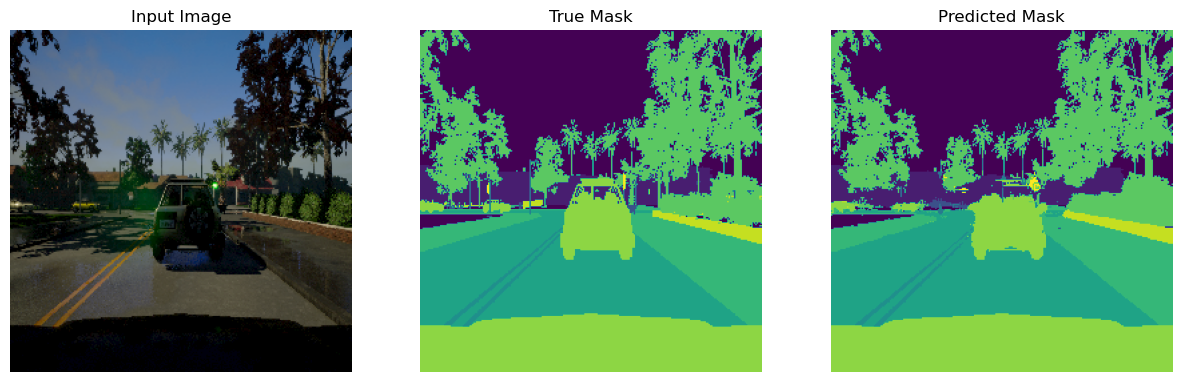

1/1 [==============================] - 0s 23ms/step


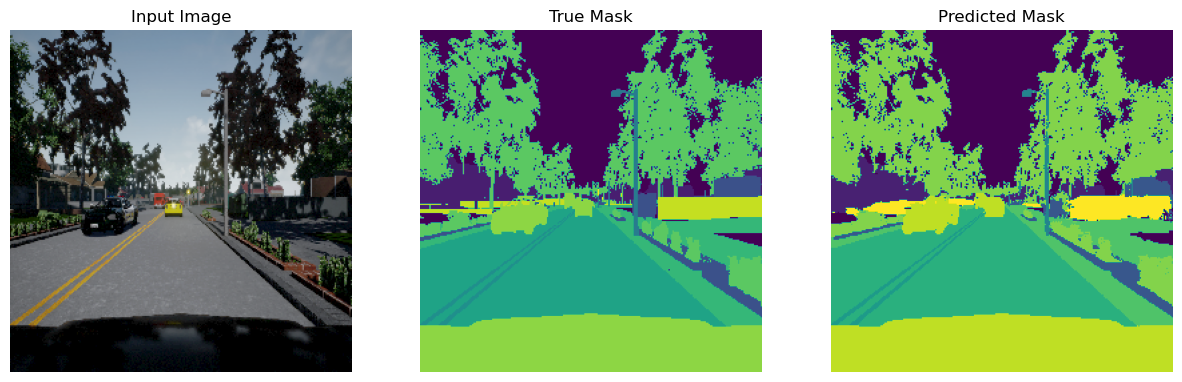

1/1 [==============================] - 0s 20ms/step


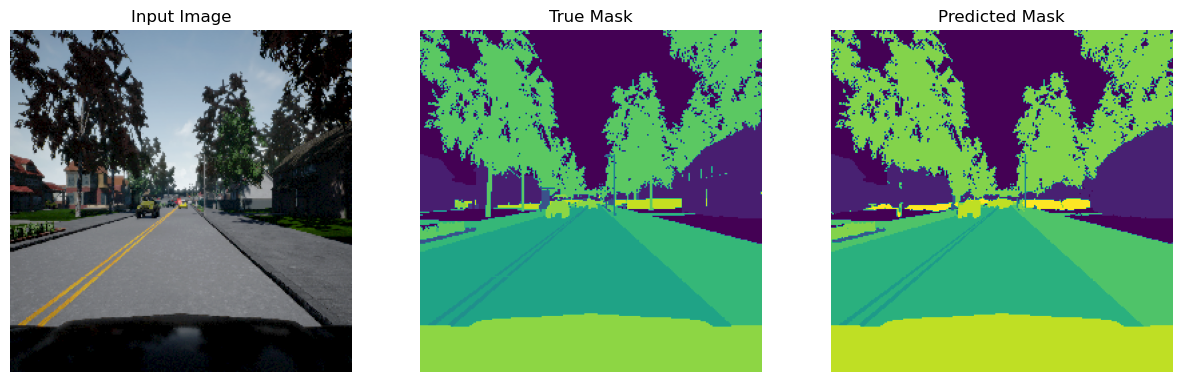

In [73]:
#unet3_model = tf.keras.models.load_model('./models/model3.keras')
#with open('./models/model3Hist', 'rb') as f:
#    model3_hist = pickle.load(f)
show_predictions(unet3_model, val_data, 3)

# Exploring metrics
We will finally explore the performance of each model graphed against each other. Here, we will first look at train and validation accuracy across all three models. While accuracy isn't the best metric for semantic segmentation, it is still useful to gain an understanding for how the models are performing.  

Here all the models performed relatively similar to one another. However, the Upsampling2D and Conv2dTranspose were the closest in performance. Surprisingly, the Upsampling2D model performed better than the Conv2DTranspose model, despite it technically being a simpler implentation of upsampling

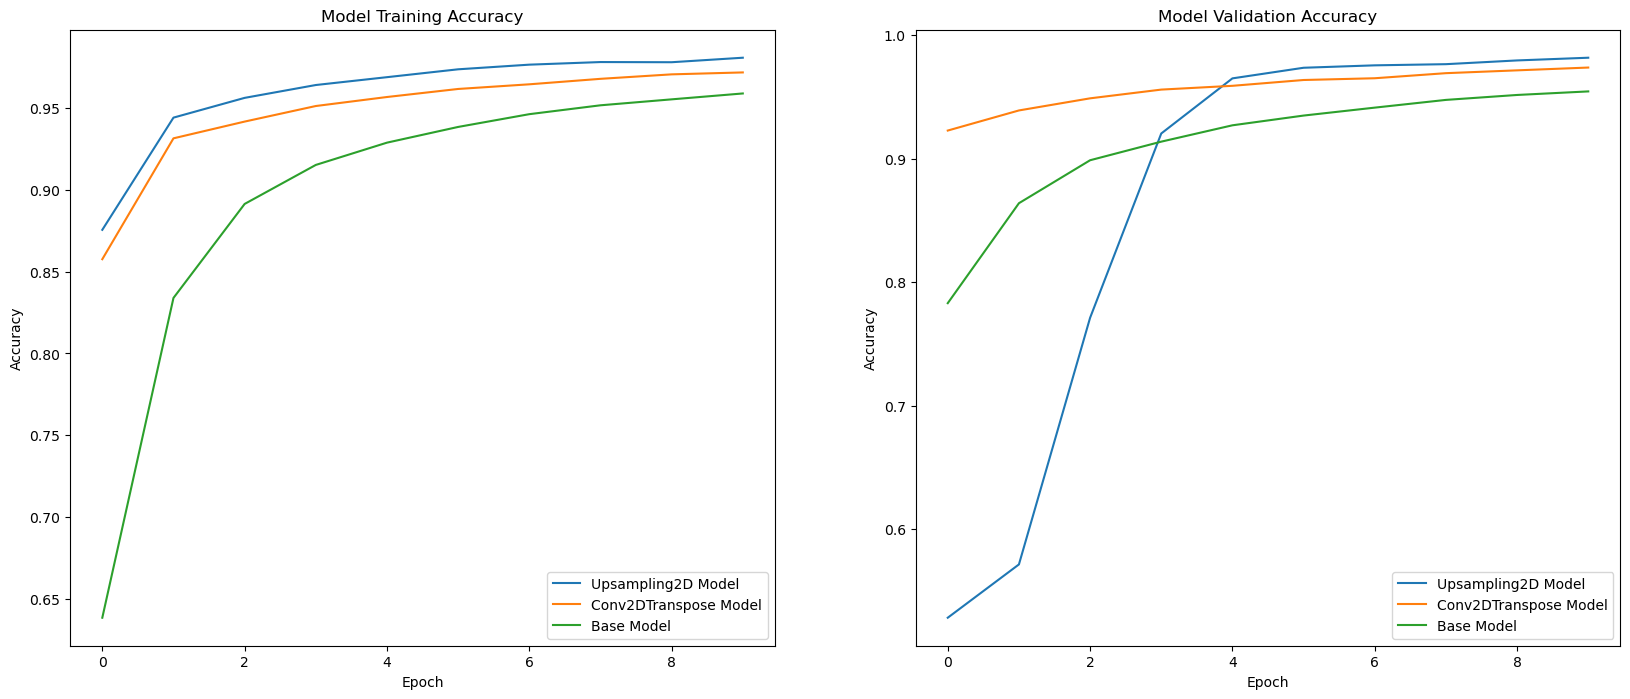

In [64]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

ax[0].plot(model2_hist.history['accuracy'])
ax[0].plot(model3_hist.history['accuracy'])
ax[0].plot(model1_hist.history['accuracy'])
ax[0].set_title('Model Training Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Upsampling2D Model', 'Conv2DTranspose Model', 'Base Model'])

ax[1].plot(model2_hist.history['val_accuracy'])
ax[1].plot(model3_hist.history['val_accuracy'])
ax[1].plot(model1_hist.history['val_accuracy'])
ax[1].set_title('Model Validation Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Upsampling2D Model', 'Conv2DTranspose Model', 'Base Model'])

Next we'll look at a metric that is actually important for measuring the performance of semantic segmentation, IoU. In our case, we are looking at the mean IoU, as opposed to class specific IoU. It measures the overlap between the predicted segmented regions and the true values.  

When looking at this metric, there is a clearer gap between the baseline and the other two models. We can see that the Upsampling2D model is still performing better than the Conv2DTranspose and thus will select this model as the best performing one.

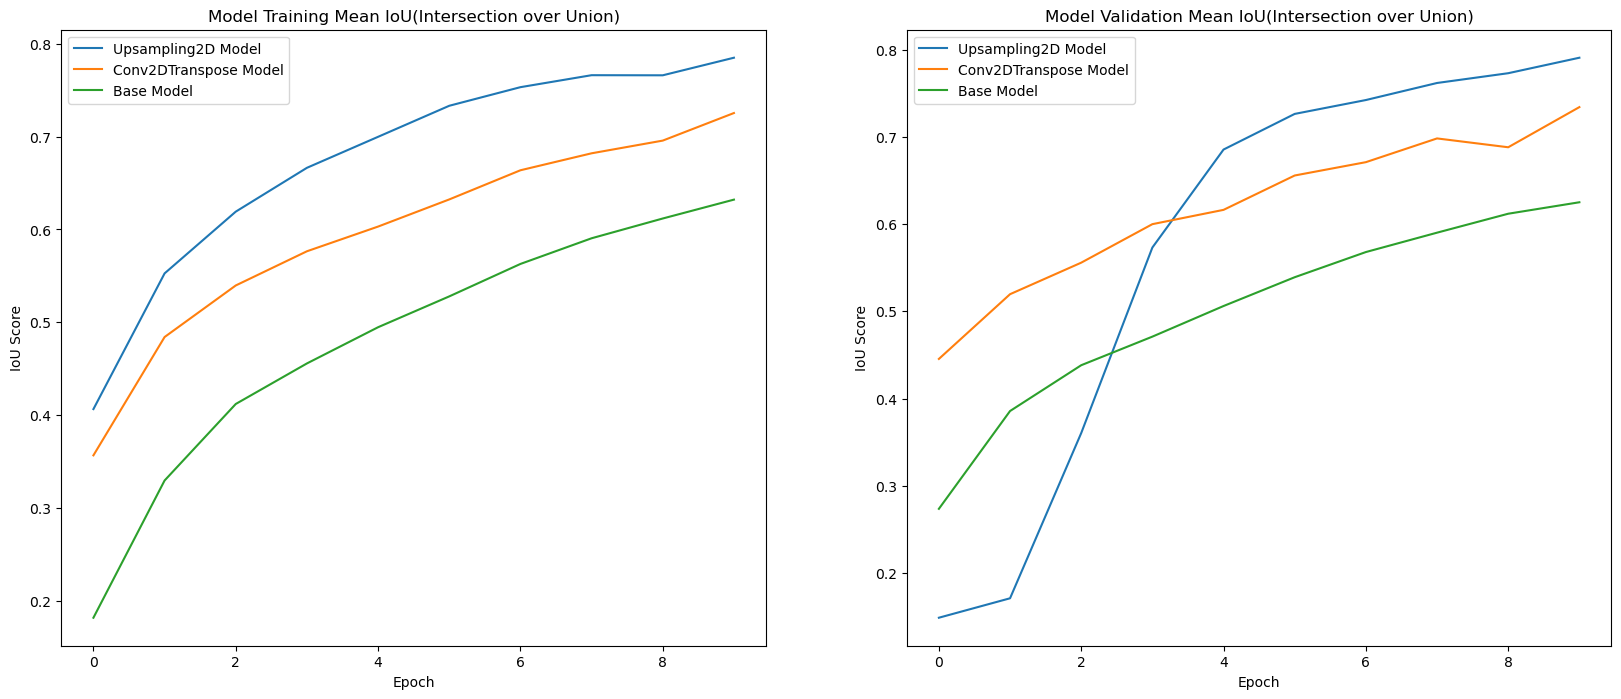

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

ax[0].plot(model2_hist.history['updated_mean_io_u_3'])
ax[0].plot(model3_hist.history['updated_mean_io_u_7'])
ax[0].plot(model1_hist.history['updated_mean_io_u_6'])
ax[0].set_title('Model Training Mean IoU(Intersection over Union)')
ax[0].set_ylabel('IoU Score')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Upsampling2D Model', 'Conv2DTranspose Model', 'Base Model'])

ax[1].plot(model2_hist.history['val_updated_mean_io_u_3'])
ax[1].plot(model3_hist.history['val_updated_mean_io_u_7'])
ax[1].plot(model1_hist.history['val_updated_mean_io_u_6'])
ax[1].set_title('Model Validation Mean IoU(Intersection over Union)')
ax[1].set_ylabel('IoU Score')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Upsampling2D Model', 'Conv2DTranspose Model', 'Base Model'])

https://distill.pub/2016/deconv-checkerboard/  
There are a couple of reasons that might explain why upsampling2D is performing better. First, conv2dtranspose is more prone to creating checkerboard artifacts because of overlaps when two axes are multiplied together. Also since the upsampling and feature transformation is separated (upsampling + conv2d), the network might be learning better as opposed to having them done simultaneously with conv2dtranspose.